In [1]:
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from utils.preprocessing import remove_punctuation
from underthesea import word_tokenize
from utils.classify import feedbackSentimentAnalysis

In [2]:
from word2vec.Word2Vec import studentFeedbackWord2Vec

w2v_skipgram = studentFeedbackWord2Vec()
w2v_skipgram.load("word2vec/skipgram_model.bin")

In [3]:
train_df = pd.read_csv("Data/train.csv")
dev_df   = pd.read_csv("Data/dev.csv")
test_df  = pd.read_csv("Data/test.csv")

X_train, y_train = train_df["sents"], train_df["sentiments"]
X_dev, y_dev = dev_df["sents"], dev_df["sentiments"]
X_test, y_test = test_df["sents"], test_df["sentiments"]

In [4]:
corpus_df = pd.read_csv("Data/corpus.csv")
X = corpus_df["sents"]
y = corpus_df["sentiments"]

## Processing

In [5]:
def tokenize_vietnamese_sentence(sentence):
    return word_tokenize(remove_punctuation(sentence.lower()))

X_tokenized = [tokenize_vietnamese_sentence(x) for x in X]
X_tokenized

[['slide', 'giáo trình', 'đầy đủ'],
 ['nhiệt tình', 'giảng dạy', 'gần gũi', 'với', 'sinh viên'],
 ['đi', 'học', 'đầy đủ', 'full điểm', 'chuyên', 'cần'],
 ['chưa',
  'áp dụng',
  'công nghệ thông tin',
  'và',
  'các',
  'thiết bị',
  'hỗ trợ',
  'cho',
  'việc',
  'giảng dạy'],
 ['thầy',
  'giảng',
  'bài',
  'hay',
  'có',
  'nhiều',
  'bài tập',
  'ví dụ',
  'ngay',
  'trên',
  'lớp'],
 ['giảng viên',
  'đảm bảo',
  'thời gian',
  'lên',
  'lớp',
  'tích cực',
  'trả lời',
  'câu',
  'hỏi',
  'của',
  'sinh viên',
  'thường xuyên',
  'đặt',
  'câu',
  'hỏi',
  'cho',
  'sinh viên'],
 ['em',
  'sẽ',
  'nợ',
  'môn',
  'này',
  'nhưng',
  'em',
  'sẽ',
  'học',
  'lại',
  'ở',
  'các',
  'học kỳ',
  'kế tiếp'],
 ['thời lượng',
  'học',
  'quá',
  'dài',
  'không',
  'đảm bảo',
  'tiếp thu',
  'hiệu quả'],
 ['nội dung',
  'môn học',
  'có',
  'phần',
  'thiếu',
  'trọng tâm',
  'hầu như',
  'là',
  'chung chung',
  'khái quát',
  'khiến',
  'sinh viên',
  'rất',
  'khó',
  'nắm',
  'đượ

In [8]:
class Sequencer:
    def __init__(self, all_words, max_words, seq_len, embedding_matrix ):
        self.seq_len = seq_len
        self.embed_matrix = embedding_matrix
        temp_vocab = list(set(all_words))
        self.vocab = []
        self.word_cnts = {}
        for word in temp_vocab:
            count = len([0 for w in all_words if w == word])
            self.word_cnts[word] = count
            counts = list(self.word_cnts.values())
            indexes = list(range(len(counts)))
        
        count = 0
        while count + 1 != len(counts):
            count = 0
            for i in range(len(counts)-1):
                if counts[i] < counts[i+1]:
                    counts[i+1],counts[i] = counts[i],counts[i+1]
                    indexes[i],indexes[i+1] = indexes[i+1],indexes[i]
                else:
                    count += 1
        
        for ind in indexes[:max_words]:
            self.vocab.append(temp_vocab[ind])
                    
    def textToVector(self,text):
        tokens = word_tokenize(text)
        len_v = len(tokens)-1 if len(tokens) < self.seq_len else self.seq_len-1
        vec = []
        for token in tokens[:len_v]:
            try:
                vec.append(self.embed_matrix.get_vector(token))
            except Exception as E:
                pass
        
        last_pieces = self.seq_len - len(vec)
        for i in range(last_pieces):
            vec.append(np.zeros(200,))
        
        return np.asarray(vec).flatten()

In [9]:
sequencer = Sequencer(all_words = [token for seq in X_tokenized for token in seq],
              max_words = 1200,
              seq_len = 15,
              embedding_matrix = w2v_skipgram
             )

In [10]:
test_vec = sequencer.textToVector("Thầy dạy hay")
test_vec

array([ 0.09250087,  0.09543615, -0.04298763, ...,  0.        ,
        0.        ,  0.        ])

In [11]:
test_vec.shape

(3000,)

In [12]:
X_train_vector = [sequencer.textToVector(x) for x in X_train]
X_train_vector[0]

array([-0.07413797,  0.14278117,  0.09009963, ...,  0.        ,
        0.        ,  0.        ])

### Ridge Regression

In [13]:
ridge_classifier = RidgeClassifier(alpha=1.0)
ridge_classifier.fit(X_train_vector, y_train)

RidgeClassifier()

In [14]:
X_test_vector = [sequencer.textToVector(x) for x in X_test]
ridge_predictions = ridge_classifier.predict(X_test_vector)

print("Confusion Matrix:")
print(confusion_matrix(y_test, ridge_predictions))

ridge_accuracy = accuracy_score(y_test, ridge_predictions)
ridge_precision = precision_score(y_test, ridge_predictions, average="weighted")
ridge_recall = recall_score(y_test, ridge_predictions, average="weighted")
ridge_f1 = f1_score(y_test, ridge_predictions, average="weighted")

print("Accuracy: ", ridge_accuracy)
print("Precision: ", ridge_precision)
print("Recall: ", ridge_recall)
print("F1-Score: ", ridge_f1)

Confusion Matrix:
[[1283    3  123]
 [  75    3   89]
 [ 124    4 1462]]
Accuracy:  0.8679722046746684
Precision:  0.8397158202869779
Recall:  0.8679722046746684
F1-Score:  0.8466959154830171


In [15]:
lr_result = classification_report(y_test, ridge_predictions)
print(lr_result)

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1409
           1       0.30      0.02      0.03       167
           2       0.87      0.92      0.90      1590

    accuracy                           0.87      3166
   macro avg       0.68      0.62      0.61      3166
weighted avg       0.84      0.87      0.85      3166



In [16]:
example = "Thầy dạy tuyệt vời ."
vector = np.array([sequencer.textToVector(example)])
prediction = ridge_classifier.predict(vector)
sentiment = feedbackSentimentAnalysis(prediction)
print("Sentiment: ", sentiment)

Sentiment:  Tích Cực


<Axes: >

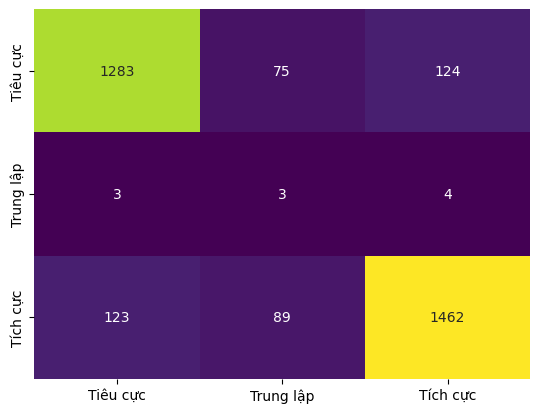

In [17]:
import seaborn as sns
lr_conf_matrix = confusion_matrix(ridge_predictions, y_test)
sns.heatmap(lr_conf_matrix, annot=True, fmt="d",cmap="viridis", cbar=False,
                 xticklabels=["Tiêu cực", "Trung lập", "Tích cực"], yticklabels=["Tiêu cực", "Trung lập", "Tích cực"])

### SVM

In [18]:
SVM_classifier = SVC()
SVM_classifier.fit(X_train_vector, y_train)

SVC()

In [19]:
SVM_predictions = SVM_classifier.predict(X_test_vector)

print("Confusion Matrix:")
print(confusion_matrix(y_test, SVM_predictions))

SVM_accuracy = accuracy_score(y_test, SVM_predictions)
SVM_precision = precision_score(y_test, SVM_predictions, average="weighted")
SVM_recall = recall_score(y_test, SVM_predictions, average="weighted")
SVM_f1 = f1_score(y_test, SVM_predictions, average="weighted")

print("Accuracy: ", SVM_accuracy)
print("Precision: ", SVM_precision)
print("Recall: ", SVM_recall)
print("F1-Score: ", SVM_f1)

Confusion Matrix:
[[1330    2   77]
 [  89   11   67]
 [ 142    3 1445]]
Accuracy:  0.8799747315224258
Precision:  0.8721462888532049
Recall:  0.8799747315224258
F1-Score:  0.8614856942891491


In [34]:
svm_result = classification_report(y_test,SVM_predictions)
print(svm_result)

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1409
           1       0.67      0.06      0.11       167
           2       0.91      0.91      0.91      1590

    accuracy                           0.88      3166
   macro avg       0.81      0.64      0.64      3166
weighted avg       0.87      0.88      0.86      3166



In [20]:
example2 = "Thầy dạy rất hay, truyền đạt dễ hiểu. Học sinh rất thích."
vector2 = np.array([sequencer.textToVector(example2)])
result2 = SVM_classifier.predict(vector2)
sentiment = feedbackSentimentAnalysis(result2)
print("Sentiment: ", sentiment)

Sentiment:  Tích Cực


<Axes: >

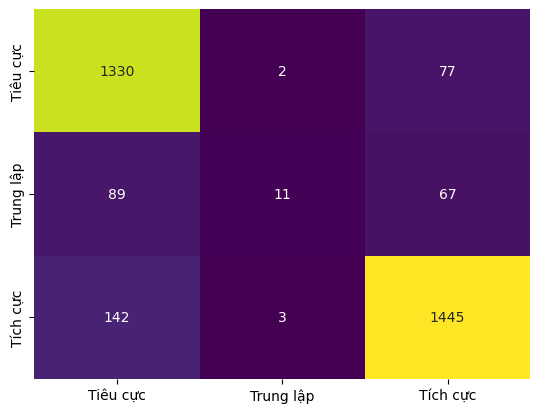

In [21]:
import seaborn as sns
svm_conf_matrix = confusion_matrix( y_test, SVM_predictions)
sns.heatmap(svm_conf_matrix, annot=True, fmt="d",cmap="viridis", cbar=False,
                 xticklabels=["Tiêu cực", "Trung lập", "Tích cực"], yticklabels=["Tiêu cực", "Trung lập", "Tích cực"])